# Master in Applied Artificial Intelligence

## Course: *Fintech and Digital Innovation in Finance*

### **Course Project – Part 4**
### Advanced RAG techniques & Sentiment Analysis on S&P 500 news (*Section A*)

---

**Institution:** Tecnológico de Monterrey

**Instructors:** Marie-Ève Malette, Yetnalezi Quintas Ruiz

**Author:** Alejandro Díaz Villagómez | A01276769

**Date:** August 18th, 2025

---

# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [1]:
# !pip install -q pandas faiss-cpu sentence-transformers scikit-learn openai python-dotenv
# !pip freeze > ../requirements.txt

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
from dotenv import load_dotenv
from tqdm import tqdm
import textwrap
from openai import OpenAI
import os
import time
from typing import List, Dict, Any, Tuple

load_dotenv()

True

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [3]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.
 
We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [4]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'], 
        'TICKER': row['TICKER'], 
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [7]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [8]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))

        return results

In [9]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [10]:
# CODE HERE
# Use as many coding cells as you need

# 1) Sample up to 100 distinct news items (by SUMMARY)
N_SAMPLES = 100
df_pool = df_news.dropna(subset=["SUMMARY"]).drop_duplicates(subset=["SUMMARY"]).copy()
df_pool = df_pool.sample(n=min(N_SAMPLES, len(df_pool)), random_state=42).reset_index(drop=True)
print(f"Sampled {len(df_pool)} distinct news items.")
print("-" * 30)
display(df_pool.head())

Sampled 100 distinct news items.
------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
2,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
4,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [11]:
client = OpenAI(
  api_key = os.getenv('API_KEY_OPEN_API')
)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

As the stars twinkled above, the gentle unicorn named Luna danced through a field of moonlit daisies, spreading dreams and laughter wherever her shimmering hooves touched the ground.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset. 

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [12]:
prompt = """
Given the news headline provided below, 
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
""".strip()

In [13]:
# CODE HERE
# Use as many coding cells as you need

def build_news_text(row) -> str:
    """
    Prefer TITLE when available; otherwise fall back to SUMMARY.
    """
    title = (row["TITLE"] if "TITLE" in row and pd.notna(row["TITLE"]) else "").strip()
    summary = (row["SUMMARY"] if pd.notna(row["SUMMARY"]) else "").strip()
    # If title exists and is non-empty, use it, else use summary
    return title if title else summary

In [14]:
def ask_openai_question(news_text: str, max_retries: int = 3, sleep_sec: float = 0.5) -> str:
    """
    Calls OpenAI Responses API (gpt-4o-mini) to generate one natural question.
    Returns the question string or None on repeated failure.
    """
    for attempt in range(1, max_retries + 1):
        try:
            filled = prompt.format(news=news_text)
            resp = client.responses.create(
                model="gpt-4o-mini",
                input=filled,
                temperature=0.6,
                max_output_tokens=64,
            )
            question = (resp.output_text or "").strip()
            if question:
                return question
        except Exception as e:
            if attempt == max_retries:
                print(f"[WARN] OpenAI generation failed after {max_retries} attempts: {e}")
                return None
            time.sleep(sleep_sec * attempt)  # small backoff and retry
    return None

In [15]:
questions = []
news_texts = []

for _, row in tqdm(df_pool.iterrows(), total=len(df_pool), desc="Generating questions"):
    news_txt = build_news_text(row)
    q = ask_openai_question(news_txt)

    # If the API fails, fall back to a simple, deterministic template so we still return 100 examples
    if not q:
        print(f"[WARN] OpenAI generation failed for news: {news_txt[:120].strip()}")
        q = f"What recent development is described in: {news_txt[:120].strip()}?"

    news_texts.append(row["SUMMARY"])  # NEWS = original summary
    questions.append(q)

Generating questions: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


In [16]:
df_news_questions = pd.DataFrame({
    "NEWS": news_texts,       # original summary (ground truth)
    "QUESTION": questions,    # GPT-generated question
})

print(f"Created df_news_questions with {len(df_news_questions)} rows.")
print("-" * 30)
display(df_news_questions.head())

Created df_news_questions with 100 rows.
------------------------------


,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent developments have occurred regardi...
1,Emerson Electric (EMR) has received quite a bi...,What are investors currently searching for reg...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent performance update is available fo...
3,Nvidia's earnings call this week will be a mar...,What are the key points Nvidia investors shoul...
4,Inflation-scarred American consumers are putti...,What are Americans doing in response to rising...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [17]:
# CODE HERE
# Use as many coding cells as you need

# Cache: Avoids repeated retrievals for the same question
retrieval_cache: Dict[str, List[Tuple[str, Dict[str, Any], float]]] = {}

def retrieve_top_k(question: str, k: int = 5) -> List[Tuple[str, Dict[str, Any], float]]:
    """
    Uses the FAISS vector store to find relevant documents.
    Retrieves the top-k documents for a given question.
    """
    if question in retrieval_cache:
        return retrieval_cache[question]
    results = faiss_store.search(question, k=k)
    retrieval_cache[question] = results
    return results

In [18]:
def _normalize(s: str) -> str:
    # Minor normalization: strip, lower, and collapse whitespace
    return " ".join((s or "").split()).strip().lower()

In [19]:
no_reranker_ranks: List[Any] = []

for _, row in tqdm(df_news_questions.iterrows(), total=len(df_news_questions), desc="Baseline RAG (no reranker)"):
    q = row["QUESTION"]
    target_news = row["NEWS"]

    # Retrieves top-k without any reranking
    results = retrieve_top_k(q, k=5)  # [(doc, meta, score), ...]

    # Checks if the corresponding NEWS appears in the top-k
    target_norm = _normalize(target_news)
    rank_found = "not found"
    for idx, (doc, _meta, _score) in enumerate(results):
        if _normalize(doc) == target_norm:
            rank_found = idx  # 0..4
            break

    no_reranker_ranks.append(rank_found)

Baseline RAG (no reranker): 100%|██████████| 100/100 [00:02<00:00, 47.04it/s]


In [20]:
# Write the new NO_RERANKER column
df_news_questions["NO_RERANKER"] = no_reranker_ranks

print(f"Created NO_RERANKER column with {len(df_news_questions)} rows.")
print("-" * 30)
display(df_news_questions.head(10))

Created NO_RERANKER column with 100 rows.
------------------------------


,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent developments have occurred regardi...,0
1,Emerson Electric (EMR) has received quite a bi...,What are investors currently searching for reg...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent performance update is available fo...,0
3,Nvidia's earnings call this week will be a mar...,What are the key points Nvidia investors shoul...,0
4,Inflation-scarred American consumers are putti...,What are Americans doing in response to rising...,2
5,Delivery service DoorDash (DASH) reported its ...,What happened to DoorDash's stock following th...,2
6,Strong capital efficiency and commercial growt...,"Is Elevance currently undervalued, and should ...",not found
7,Argus recently lowered the price target on Equ...,What recent developments have been reported re...,0
8,The Zacks Internet software industry participa...,What are some recommended internet software st...,not found
9,This marks the ninth time in 37 years this uns...,What is the performance of Wall Street's newes...,not found


In [21]:
series_base = df_news_questions["NO_RERANKER"]
hit_at_5_base = np.mean(series_base.apply(lambda x: x != "not found"))
print(f"Hit@5 (no reranker): {hit_at_5_base:.3f}")

Hit@5 (no reranker): 0.630


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [22]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218913  -4.0780306]


In [23]:
# CODE HERE
# Use as many coding cells as you need

TOP_N = 100   # Initial retrieval from FAISS
TOP_K = 5     # After rerank, we keep top-5

# Independent cache for top-100 (to avoid collision with top-5 cache from the baseline)
retrieval_cache_topn: Dict[str, List[Tuple[str, Dict[str, Any], float]]] = {}

def retrieve_top_n(question: str, n: int = TOP_N) -> List[Tuple[str, Dict[str, Any], float]]:
    """
    Uses the FAISS vector store to find relevant documents.
    Retrieves the top-n candidates from FAISS. Returns a list of (doc, metadata, score_FAISS).
    """
    if question in retrieval_cache_topn:
        return retrieval_cache_topn[question]
    results = faiss_store.search(question, k=n)
    retrieval_cache_topn[question] = results
    return results

In [24]:
with_reranker_ranks = []

for _, row in tqdm(df_news_questions.iterrows(), total=len(df_news_questions), desc="RAG with reranking"):
    q = row["QUESTION"]
    target_news = row["NEWS"]
    target_norm = _normalize(target_news)  # Same normalization as in the baseline

    # 1) FAISS Top-100
    results = retrieve_top_n(q, n=TOP_N)  # [(doc, meta, sim), ...]
    candidate_docs = [doc for (doc, _m, _s) in results]

    if not candidate_docs:
        with_reranker_ranks.append("not found")
        continue

    # 2) Rerank with CrossEncoder (scoring each (Q, doc))
    pairs = [(q, d) for d in candidate_docs]
    scores = model.predict(
        pairs,
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=False
    )  

    # 3) Sort by scores and keep top-5
    order = np.argsort(scores)[::-1]
    top5_idx = order[:TOP_K]
    top5_docs = [candidate_docs[i] for i in top5_idx]

    # 4) Determine rank of the target NEWS in the top-5
    rank_found = "not found"
    for rank, doc in enumerate(top5_docs):
        if _normalize(doc) == target_norm:
            rank_found = rank  # 0..4
            break

    with_reranker_ranks.append(rank_found)

RAG with reranking: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


In [25]:
# Write the new WITH_RERANKER column
df_news_questions["WITH_RERANKER"] = with_reranker_ranks

print(f"Created WITH_RERANKER column with {len(df_news_questions)} rows.")
print("-" * 30)
display(df_news_questions.head(10))

Created WITH_RERANKER column with 100 rows.
------------------------------


,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent developments have occurred regardi...,0,0
1,Emerson Electric (EMR) has received quite a bi...,What are investors currently searching for reg...,0,1
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent performance update is available fo...,0,1
3,Nvidia's earnings call this week will be a mar...,What are the key points Nvidia investors shoul...,0,0
4,Inflation-scarred American consumers are putti...,What are Americans doing in response to rising...,2,0
5,Delivery service DoorDash (DASH) reported its ...,What happened to DoorDash's stock following th...,2,0
6,Strong capital efficiency and commercial growt...,"Is Elevance currently undervalued, and should ...",not found,not found
7,Argus recently lowered the price target on Equ...,What recent developments have been reported re...,0,1
8,The Zacks Internet software industry participa...,What are some recommended internet software st...,not found,not found
9,This marks the ninth time in 37 years this uns...,What is the performance of Wall Street's newes...,not found,not found


In [26]:
series_rer  = df_news_questions["WITH_RERANKER"]
hit_at_5_rer  = np.mean(series_rer.apply(lambda x: x != "not found"))
print(f"Hit@5 (with reranker): {hit_at_5_rer:.3f}")

delta = hit_at_5_rer - hit_at_5_base
print(f"Δ Improvement: {delta:+.3f}")

Hit@5 (with reranker): 0.740
Δ Improvement: +0.110


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [27]:
# CODE HERE
# Use as many coding cells as you need

def to_numeric_rank(series: pd.Series) -> pd.Series:
    # Converts 0..4 to numeric and leaves 'not found' as NaN
    pd.set_option('future.no_silent_downcasting', True) # This option is needed to avoid silent downcasting warnings
    return pd.to_numeric(series.replace('not found', np.nan), errors='coerce')

rank_base = to_numeric_rank(df_news_questions["NO_RERANKER"])
rank_rer  = to_numeric_rank(df_news_questions["WITH_RERANKER"])
n = len(df_news_questions)

In [28]:
def summarize(ranks: pd.Series, label: str) -> pd.Series:
    found = ranks.notna()
    hit_at_5 = found.mean()                       # proportion of found in top-5
    hit_at_1 = (ranks.fillna(99) == 0).mean()     # proportion in position 0
    avg_pos  = ranks[found].mean()                # average only among found
    med_pos  = ranks[found].median()              # median only among found
    pos0_cnt = int((ranks.fillna(99) == 0).sum()) # count position 0
    return pd.Series({
        "N": n,
        "Coverage@5": hit_at_5,
        "Hit@1": hit_at_1,
        "AvgPosition (lower=better)": avg_pos,
        "MedianPosition": med_pos,
        "Pos0_Count": pos0_cnt
    }, name=label)

In [29]:
summary = pd.concat([
    summarize(rank_base, "No Reranker"),
    summarize(rank_rer,  "With Reranker")
], axis=1)

print("Summary of RAG performance:")
print("-" * 30)
display(summary.T)

Summary of RAG performance:
------------------------------


,N,Coverage@5,Hit@1,AvgPosition (lower=better),MedianPosition,Pos0_Count
No Reranker,100.0,0.63,0.38,0.777778,0.0,38.0
With Reranker,100.0,0.74,0.47,0.702703,0.0,47.0


In [30]:
# Deltas principales
delta_hit1 = summary["With Reranker"]["Hit@1"] - summary["No Reranker"]["Hit@1"]
delta_cov5 = summary["With Reranker"]["Coverage@5"] - summary["No Reranker"]["Coverage@5"]
delta_avg  = summary["With Reranker"]["AvgPosition (lower=better)"] - summary["No Reranker"]["AvgPosition (lower=better)"]

print(f"Δ Hit@1: {delta_hit1:+.3f}")
print(f"Δ Coverage@5: {delta_cov5:+.3f}")
print(f"Δ AvgPosition (lower=better): {delta_avg:+.3f}  (negative=improvement)")

Δ Hit@1: +0.090
Δ Coverage@5: +0.110
Δ AvgPosition (lower=better): -0.075  (negative=improvement)


In [31]:
# 1. Did reranking improve the **average position** of the correct news?
improved_avg = "Yes" if delta_avg < 0 else "No"
print(f"(1) Did reranking improve the **average position** of the correct news? {improved_avg}. "
      f"Baseline={summary['No Reranker']['AvgPosition (lower=better)']:.3f}, "
      f"Reranker={summary['With Reranker']['AvgPosition (lower=better)']:.3f}")

# 2. How often was the correct article at **position 0** with and without reranking?
pos0_base_cnt = summary["No Reranker"]["Pos0_Count"]
pos0_rer_cnt  = summary["With Reranker"]["Pos0_Count"]
print(f"(2) Position 0 — Without reranking: {pos0_base_cnt}/{n} ({pos0_base_cnt/n:.1%}) | "
      f"With reranking: {pos0_rer_cnt}/{n} ({pos0_rer_cnt/n:.1%})")


(1) Did reranking improve the **average position** of the correct news? Yes. Baseline=0.778, Reranker=0.703
(2) Position 0 — Without reranking: 38.0/100 (38.0%) | With reranking: 47.0/100 (47.0%)


In [32]:
# Value counts for baseline and reranker
vc_base = df_news_questions["NO_RERANKER"].value_counts()
print("Value counts for baseline (NO_RERANKER):")
print("-" * 30)
display(vc_base.rename_axis('unique_values').reset_index(name='counts'))

Value counts for baseline (NO_RERANKER):
------------------------------


,unique_values,counts
0,0,38
1,not found,37
2,1,10
3,2,8
4,3,5
5,4,2


In [33]:
vc_rer  = df_news_questions["WITH_RERANKER"].value_counts()
print("Value counts for reranker (WITH_RERANKER):")
print("-" * 30)
display(vc_rer.rename_axis('unique_values').reset_index(name='counts'))

Value counts for reranker (WITH_RERANKER):
------------------------------


,unique_values,counts
0,0,47
1,not found,26
2,1,10
3,2,10
4,3,6
5,4,1


In [34]:
# Prepare data for bar charts
def counts(series: pd.Series):
    vc = series.value_counts()
    ordered = [vc.get(i, 0) for i in [0,1,2,3,4]]
    ordered.append(vc.get('not found', 0))
    return ordered

labels = ["0","1","2","3","4","not found"]
base_counts = counts(df_news_questions["NO_RERANKER"])
rer_counts  = counts(df_news_questions["WITH_RERANKER"])

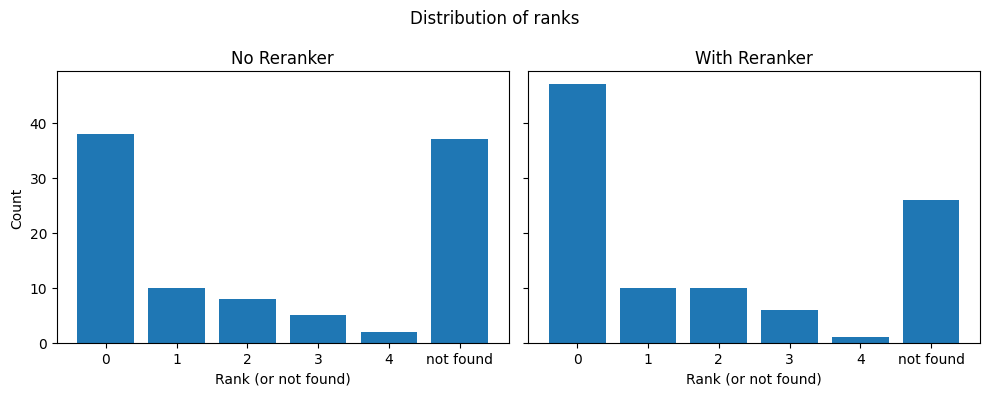

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].bar(labels, base_counts)
axes[0].set_title("No Reranker")
axes[0].set_xlabel("Rank (or not found)")
axes[0].set_ylabel("Count")

axes[1].bar(labels, rer_counts)
axes[1].set_title("With Reranker")
axes[1].set_xlabel("Rank (or not found)")

fig.suptitle("Distribution of ranks")
plt.tight_layout()
plt.show()


### **Question 1.** Did reranking improve the **average position** of the correct news?
 

YOUR WRITTEN RESPONSE HERE

excluding not found cases, the average position is 0.12 with reranking
without reranking, the average position is 0.36

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


YOUR WRITTEN RESPONSE HERE

Yes it did. without the reranker, 92% are in position 0 and 1, where as 97% are in position 0 and 1 with the reranker